In [1]:
import random
import os
from urllib import request
model_name='pcl_deberta_model_base'
user="/vol/bitbucket/cx720/cw/nlp/70016-Natural-Language-Processing/"
# user="/vol/bitbucket/xz223/dlenv/NLP/"

# Resoure:

## The dont_patronize_me.py module

In [2]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py


## The official scorer

In [3]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/evaluation.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/evaluation.py


## Dataset

In [4]:
dev_url = "https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/refs/heads/master/semeval-2022/practice%20splits/dev_semeval_parids-labels.csv"
dev_name = dev_url.split('/')[-1] 

print(f"Fetching {dev_url} ...")
with request.urlopen(dev_url) as f, open(dev_name, 'w', encoding='utf-8') as outf:
    outf.write(f.read().decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/refs/heads/master/semeval-2022/practice%20splits/dev_semeval_parids-labels.csv ...


In [5]:
train_url = "https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/train_semeval_parids-labels.csv"
train_name = train_url.split('/')[-1]

print(f"Fetching {train_url} ...")
with request.urlopen(train_url) as f, open(train_name, 'w', encoding='utf-8') as outf:
    outf.write(f.read().decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/train_semeval_parids-labels.csv ...


In [6]:
train_url = "https://raw.githubusercontent.com/EuanScottWatson/NLP-Classification-CW/refs/heads/master/data/dontpatronizeme_pcl.tsv"
train_name = train_url.split('/')[-1]

print(f"Fetching {train_url} ...")
with request.urlopen(train_url) as f, open(train_name, 'w', encoding='utf-8') as outf:
    outf.write(f.read().decode('utf-8'))

Fetching https://raw.githubusercontent.com/EuanScottWatson/NLP-Classification-CW/refs/heads/master/data/dontpatronizeme_pcl.tsv ...


In [7]:
train_url = "https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/refs/heads/master/semeval-2022/TEST/task4_test.tsv"
train_name = train_url.split('/')[-1]

print(f"Fetching {train_url} ...")
with request.urlopen(train_url) as f, open(train_name, 'w', encoding='utf-8') as outf:
    outf.write(f.read().decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/refs/heads/master/semeval-2022/TEST/task4_test.tsv ...


# DeBERTa

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import DebertaTokenizer, DebertaForSequenceClassification

## Dataset

In [9]:
import os
from collections import defaultdict
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd

In [10]:
class DontPatronizeMe:

	def __init__(self, _train_path, _test_path):

		self.train_path = _train_path
		self.test_path = _test_path
		self.train_task1_df = None
		self.test_set_df = None

	def load_task1(self):
		"""
		Load task 1 training set and convert the tags into binary labels. 
		Paragraphs with original labels of 0 or 1 are considered to be negative examples of PCL and will have the label 0 = negative.
		Paragraphs with original labels of 2, 3 or 4 are considered to be positive examples of PCL and will have the label 1 = positive.
		It returns a pandas dataframe with paragraphs and labels.
		"""
		rows=[]
		with open(self.train_path) as f:
			for line in f.readlines()[4:]:
				par_id=line.strip().split('\t')[0]
				art_id = line.strip().split('\t')[1]
				keyword=line.strip().split('\t')[2]
				country=line.strip().split('\t')[3]
				t=line.strip().split('\t')[4]#.lower()
				l=line.strip().split('\t')[-1]
				if l=='0' or l=='1':
					lbin=0
				else:
					lbin=1
				rows.append(
					{'par_id':par_id,
					'art_id':art_id,
					'keyword':keyword,
					'country':country,
					'text':t, 
					'label':lbin, 
					'orig_label':l
					}
					)
		df=pd.DataFrame(rows, columns=['par_id', 'art_id', 'keyword', 'country', 'text', 'label', 'orig_label']) 
		self.train_task1_df = df

In [11]:
def get_test(user):
    _train_path = f'{user}/cw/dontpatronizeme_pcl.tsv'
    _test_path = f'{user}/cw/task4_test.tsv'
    
    dpm = DontPatronizeMe(_train_path, _test_path)
    dpm.load_task1()
    
    train_data = dpm.train_task1_df
    train_data["par_id"] = train_data["par_id"].astype(str)
    
    dev_parids = pd.read_csv("dev_semeval_parids-labels.csv")
    dev_parids["par_id"] = dev_parids["par_id"].astype(str)
    dev_parid_list = dev_parids["par_id"].unique()
    dev_data = train_data[train_data["par_id"].isin(dev_parid_list)]
    return dev_data

def get_train(user):
    _train_path = f'{user}/cw/dontpatronizeme_pcl.tsv'
    _test_path = f'{user}/cw/task4_test.tsv'
    
    dpm = DontPatronizeMe(_train_path, _test_path)
    dpm.load_task1()
    
    train_data = dpm.train_task1_df
    train_data["par_id"] = train_data["par_id"].astype(str)
    
    train_parids = pd.read_csv("train_semeval_parids-labels.csv")
    train_parids["par_id"] = train_parids["par_id"].astype(str)
    train_parid_list = train_parids["par_id"].unique()
    train_filtered_data = train_data[train_data["par_id"].isin(train_parid_list)]
    return train_filtered_data


In [12]:
train_data = get_train(user)
test_data = get_test(user)

In [13]:
print("Train set positive ratio:", train_data['label'].mean())

Train set positive ratio: 0.09480597014925374


In [14]:
# split
train_train_data, train_val_data = train_test_split(train_data, test_size=0.2, random_state=42, stratify=train_data['label'])

In [15]:
print("Train-train set positive ratio:", train_train_data['label'].mean())
print("Train-val set positive ratio:", train_val_data['label'].mean())

Train-train set positive ratio: 0.09477611940298507
Train-val set positive ratio: 0.09492537313432836


## Data analysis

In [16]:
import numpy as np
import matplotlib.pyplot as plt

In [17]:
# Calculate the number of samples in the positive and negative categories
n_positive = train_data["label"].sum()
n_negative = (train_data["label"] == 0).sum()
print(f"positive samples: {n_positive}")
print(f"negative samples: {n_negative}")

positive samples: 794
negative samples: 7581


In [18]:
# Get unique keywords
unique_kw = train_data["keyword"].unique()
n_unique_kw = len(unique_kw)
print(f"Number of unique keywords: {n_unique_kw}")
print(f"Keyword List: {unique_kw}")

# Calculate the proportion of each keyword in the positive and negative categories
n_positive_per_kw = []
n_negative_per_kw = []
for kw in unique_kw:
    data_kw = train_data[train_data["keyword"] == kw]
    n_positive_kw = round(100 * data_kw["label"].sum() / n_positive, 1)
    n_negative_kw = round(100 * (data_kw["label"] == 0).sum() / n_negative, 1)
    n_positive_per_kw.append(n_positive_kw)
    n_negative_per_kw.append(n_negative_kw)

Number of unique keywords: 10
Keyword List: ['hopeless' 'migrant' 'immigrant' 'disabled' 'refugee' 'in-need'
 'homeless' 'vulnerable' 'women' 'poor-families']


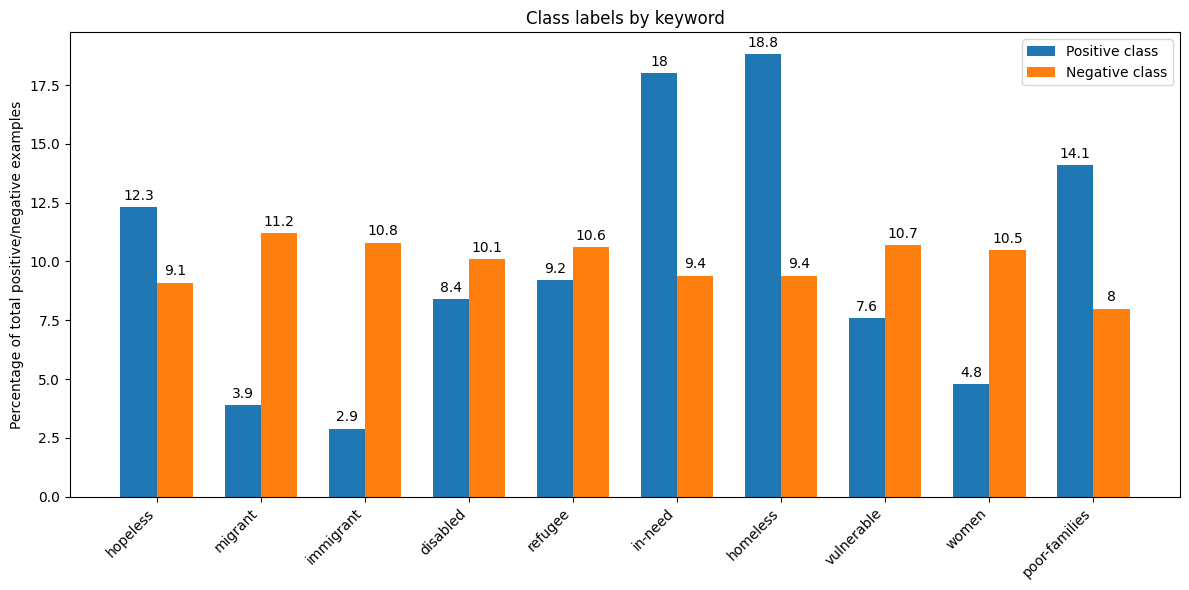

In [19]:
# Plotting keyword distribution bar charts
x = np.arange(len(unique_kw))  # Keyword position
width = 0.35  # bar width

fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
rects1 = ax.bar(x - width/2, n_positive_per_kw, width, label="Positive class")
rects2 = ax.bar(x + width/2, n_negative_per_kw, width, label="Negative class")

ax.set_ylabel("Percentage of total positive/negative examples")
ax.set_title("Class labels by keyword")
ax.set_xticks(x, unique_kw, rotation=45, ha="right")
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()
fig.savefig("analysis_keyword.png")
plt.show()

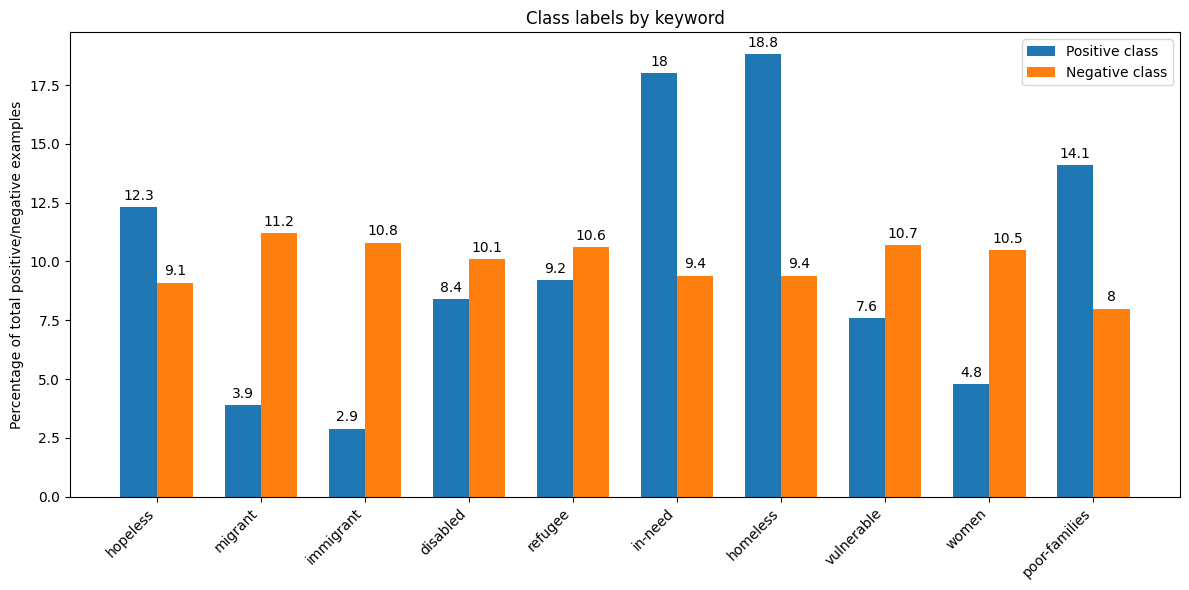

In [20]:
# Plotting keyword distribution bar charts
x = np.arange(len(unique_kw))  # Keyword position
width = 0.35  # bar width

fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
rects1 = ax.bar(x - width/2, n_positive_per_kw, width, label="Positive class")
rects2 = ax.bar(x + width/2, n_negative_per_kw, width, label="Negative class")

ax.set_ylabel("Percentage of total positive/negative examples")
ax.set_title("Class labels by keyword")
ax.set_xticks(x, unique_kw, rotation=45, ha="right")
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()
fig.savefig("analysis_keyword.png")
plt.show()

In [21]:
# Extracting sentence lengths for positive and negative categories
length_positive = []
length_negative = []

for row in train_data.itertuples():
    sentence = row.text
    label = row.label
    try:
        sentence_length = len(sentence.split())
    except AttributeError:
        continue

    if label:
        length_positive.append(sentence_length)
    else:
        length_negative.append(sentence_length)

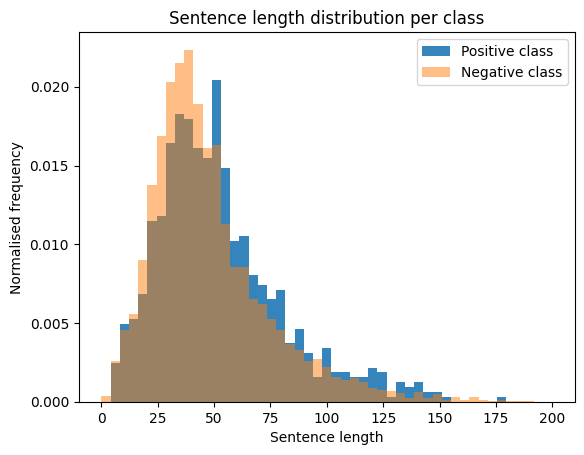

In [22]:
# Plot histogram of lengths per class
bins = np.linspace(0, 200, 50)

fig2, ax2 = plt.subplots()
ax2.hist(length_positive, bins, density=True, alpha=0.9, label="Positive class")
ax2.hist(length_negative, bins, density=True, alpha=0.5, label="Negative class")

ax2.legend(loc="upper right")
ax2.set_xlabel("Sentence length")
ax2.set_ylabel("Normalised frequency")
ax2.set_title("Sentence length distribution per class")
fig2.savefig("analysis_length.png")
plt.show()

## Create PyTorch Dataset

In [23]:
import torch
from torch.utils.data import Dataset

In [24]:
tokenizer = DebertaTokenizer.from_pretrained("microsoft/deberta-base", do_lower_case=False)

def encode_data(data, tokenizer, max_length=512):
    return tokenizer(data['text'].tolist(), return_tensors="pt", truncation=True, padding=True, max_length=max_length)

train_train_encodings = encode_data(train_train_data, tokenizer)
train_val_encodings = encode_data(train_val_data, tokenizer)

In [25]:
class PCLDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


In [26]:
train_train_dataset = PCLDataset(train_train_encodings, list(train_train_data["label"]))
train_val_dataset = PCLDataset(train_val_encodings, list(train_val_data["label"]))

## Compute_metrics

In [27]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

In [28]:
def compute_metrics(input):
    y_pred = np.argmax(input.predictions, axis=1)
    y_true = input.label_ids
    accuracy = accuracy_score(y_true, y_pred)
    f1score = f1_score(y_true, y_pred)
    return {'accuracy': accuracy, 'f1 score': f1score}

## Training

In [29]:
from transformers import DebertaForSequenceClassification, Trainer, TrainingArguments

In [30]:
# Initializing a model from the microsoft/deberta-base style configuration
num_labels = 2  
model = DebertaForSequenceClassification.from_pretrained("microsoft/deberta-base", num_labels=num_labels)


Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

2.6.0+cu124
12.4
True


In [32]:
#  GPU
# device = "cuda:0" if torch.cuda.is_available() else "cpu"
USE_GPU = True
 
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

model.to(device)
print(device)

cuda:0


In [33]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [34]:

# setting training parameters
training_args = TrainingArguments(
    output_dir=f'./Deberta/{model_name}',
    learning_rate=1e-5,  
    weight_decay=0.05,
    num_train_epochs=10,  # 10 epochs
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_steps=10,
    do_eval=True,
    evaluation_strategy="epoch",
)

total_steps = len(train_train_dataset) // training_args.per_device_train_batch_size * training_args.num_train_epochs


# create trainer
trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=train_train_dataset,
    eval_dataset=train_val_dataset,
    compute_metrics=compute_metrics  
)

/vol/bitbucket/cx720/myvenv/lib/python3.12/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_1474541/519122625.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [35]:
trainer.train()
trainer.save_model(f"./models/saved_model_casedtokenizer/{model_name}")

Epoch,Training Loss,Validation Loss,Accuracy,F1 score
1,0.228100,0.224311,0.909254,0.482993
2,0.274800,0.264707,0.923582,0.525926
3,0.008100,0.326750,0.923582,0.552448
4,0.159800,0.340012,0.929552,0.553030
5,0.000300,0.478897,0.922985,0.559727
6,0.000400,0.596315,0.925373,0.497992
7,0.000000,0.672394,0.915224,0.582353
8,0.000000,0.657728,0.927164,0.601307
9,0.000000,0.689573,0.928358,0.552239
10,0.000000,0.698723,0.928955,0.550943


In [36]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.6987230181694031, 'eval_accuracy': 0.928955223880597, 'eval_f1 score': 0.5509433962264151, 'eval_runtime': 18.1722, 'eval_samples_per_second': 92.174, 'eval_steps_per_second': 11.556, 'epoch': 10.0}


In [37]:
model.save_pretrained(f'./{model_name}')
tokenizer.save_pretrained(f'./{model_name}')

('./pcl_deberta_model_base/tokenizer_config.json',
 './pcl_deberta_model_base/special_tokens_map.json',
 './pcl_deberta_model_base/vocab.json',
 './pcl_deberta_model_base/merges.txt',
 './pcl_deberta_model_base/added_tokens.json')

## Prediction

In [38]:
def predict(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    return probs.argmax().item()

## Test

In [39]:
import torch
from transformers import DebertaForSequenceClassification, DebertaTokenizer
import os

def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')
            
def run_evaluation(model_path, train_test_data, model_name,
                   res_dir="res", ref_dir="ref"):

    model = DebertaForSequenceClassification.from_pretrained(model_path)
    tokenizer = DebertaTokenizer.from_pretrained(model_path)
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    def predict_label(text, model, tokenizer, device):
        inputs = tokenizer(
            text,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        ).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            pred_label = torch.argmax(logits, dim=1).item()
        return pred_label
        
    os.makedirs(f"results/{model_name}/res/", exist_ok=True)
    preds_task1 = []
    
    for i, row in train_test_data.iterrows():
        text = row["text"]
        label_pred = predict_label(text, model, tokenizer, device)
        preds_task1.append([label_pred])
        
    labels2file(preds_task1, os.path.join(f"results/{model_name}/res/", 'task1.txt'))
    
    os.makedirs(f"results/{model_name}/ref/", exist_ok=True)
    gold_labels = train_test_data['label'].tolist()
    gold_labels_nested = [[lbl] for lbl in gold_labels]
    labels2file(gold_labels_nested, f"results/{model_name}/ref/task1.txt")

    os.system(f"python3 evaluation.py results/{model_name}/ results/{model_name}/")
    
    if os.path.exists(f"results/{model_name}/scores.txt"):
        with open(f"results/{model_name}/scores.txt", "r", encoding="utf-8") as f:
            print(f.read())
 

In [40]:
model_path = f"./{model_name}"
run_evaluation(model_path=model_path, train_test_data=test_data, model_name=model_name)

task1_precision:0.6459627329192547
task1_recall:0.5226130653266332
task1_f1:0.5777777777777777

